<span style='color:green'> The beginning of this
   notebook is almost entirely a starter notebook given by Kaggle in order to get contestants on their way. I have adjusted a few things in order to accommodate my file structure as well as added some notes here or there but it is mainly their work/file.</span>

# Overview

Welcome to the 2018 RSNA Challenge co-hosted by Kaggle. In this competition, the primary endpoint will be the detection of bounding boxes corresponding to the diagnosis of pneumonia (e.g. lung infection) on chest radiographs, a special 2D high resolution grayscale medical image. Note that pnuemonia is just one of many possible disease processes that can occur on a chest radiograph, and that any given single image may contain 0, 1 or many boxes corresponding to possible pneumonia locations.

My name is Peter Chang, MD. I am both a radiologist physician and a data scientist / software engineer with machine learning experience. Today, in this Jupyter notebook, we will explore the 2018 RSNA Challenge dataset including underlying data structures, imaging file formats and label types.

In [1]:
import glob, pylab, pandas as pd
import pydicom, numpy as np

# Challenge Data

The challenge data is organized in several files and folders. If you are following along in the Kaggle kernel, this data will be preloaded in the `../input` directory:

In [2]:
!ls ../data

adult_patient_data.csv          stage_1_sample_submission.csv
female_adult_patient_data.csv   stage_1_test_images
logs                            stage_1_train_images
male_adult_patient_data.csv     stage_1_train_labels.csv
models                          submissions
stage_1_detailed_class_info.csv zips


The several key items in this folder:
* `stage_1_train_labels.csv`: CSV file containing training set patientIds and  labels (including bounding boxes)
* `stage_1_detailed_class_info.csv`: CSV file containing detailed labels (explored further below)
* `stage_1_train_images/`:  directory containing training set raw image (DICOM) files

Let's go ahead and take a look at the first labels CSV file first:

In [3]:
df = pd.read_csv('../data/stage_1_train_labels.csv')
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


As you can see, each row in the CSV file contains a `patientId` (one unique value per patient), a target (either 0 or 1 for absence or presence of pneumonia, respectively) and the corresponding abnormality bounding box defined by the upper-left hand corner (x, y) coordinate and its corresponding width and height. In this particular case, the patient does *not* have pneumonia and so the corresponding bounding box information is set to `NaN`. See an example case with pnuemonia here:

In [4]:
print(df.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


One important thing to keep in mind is that a given `patientId` may have **multiple** boxes if more than one area of pneumonia is detected (see below for example images).

# Overview of DICOM files and medical images

Medical images are stored in a special format known as DICOM files (`*.dcm`). They contain a combination of header metadata as well as underlying raw image arrays for pixel data. In Python, one popular library to access and manipulate DICOM files is the `pydicom` module. To use the `pydicom` library, first find the DICOM file for a given `patientId` by simply looking for the matching file in the `stage_1_train_images/` folder, and the use the `pydicom.read_file()` method to load the data:

In [5]:
patientId = df['patientId'][0]
dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [6]:
dcm_data.PatientAge, dcm_data.PatientSex, dcm_data.PatientOrientation

('51', 'F', '')

Most of the standard headers containing patient identifable information have been anonymized (removed) so we are left with a relatively sparse set of metadata. The primary field we will be accessing is the underlying pixel data as follows:

In [7]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


## Considerations

As we can see here, the pixel array data is stored as a Numpy array, a powerful numeric Python library for handling and manipulating matrix data (among other things). In addition, it is apparent here that the original radiographs have been preprocessed for us as follows:

* The relatively high dynamic range, high bit-depth original images have been rescaled to 8-bit encoding (256 grayscales). For the radiologists out there, this means that the images have been windowed and leveled already. In clinical practice, manipulating the image bit-depth is typically done manually by a radiologist to highlight certain disease processes. To visually assess the quality of the automated bit-depth downscaling and for considerations on potentially improving this baseline, consider consultation with a radiologist physician.

* The relativley large original image matrices (typically acquired at >2000 x 2000) have been resized to the data-science friendly shape of 1024 x 1024. For the purposes of this challenge, the diagnosis of most pneumonia cases can typically be made at this resolution. To visually assess the feasibility of diagnosis at this resolution, and to determine the optimal resolution for pneumonia detection (oftentimes can be done at a resolution *even smaller* than 1024 x 1024), consider consultation with a radiogist physician.

## Visualizing An Example

To take a look at this first DICOM image, let's use the `pylab.imshow()` method:

(-0.5, 1023.5, 1023.5, -0.5)

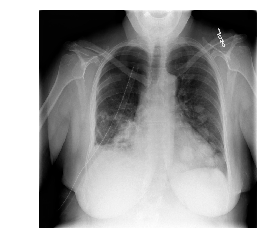

In [8]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

# Exploring the Data and Labels

As alluded to above, any given patient may potentially have many boxes if there are several different suspicious areas of pneumonia. To collapse the current CSV file dataframe into a dictionary with unique entries, consider the following method:

In [9]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '../data/stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

Let's use the method here:

In [10]:
parsed = parse_data(df)

As we saw above, patient `00436515-870c-4b36-a041-de91049b9ab4` has pnuemonia so lets check our new `parsed` dict here to see the patients corresponding bounding boxes:

In [11]:
display(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

{'dicom': '../data/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'label': 1,
 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}

# Visualizing Boxes

In order to overlay color boxes on the original grayscale DICOM files, consider using the following  methods (below, the main method `draw()` requires the method `overlay_box()`):

In [12]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

As we saw above, patient `00436515-870c-4b36-a041-de91049b9ab4` has pnuemonia so let's take a look at the overlaid bounding boxes:

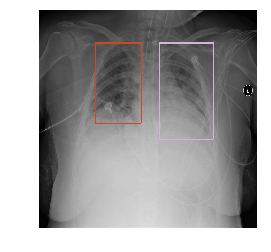

In [13]:
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

## Exploring Detailed Labels

In this challenge, the primary endpoint will be the detection of bounding boxes consisting of a binary classification---e.g. the presence or absence of pneumonia. However, in addition to the binary classification, each bounding box *without* pneumonia is further categorized into *normal* or *no lung opacity / not normal*. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image---and oftentimes this finding may mimic the appearance of true pneumonia. Keep in mind that this extra class is provided as supplemental information to help improve algorithm accuracy if needed; generation of this separate class **will not** be a formal metric used to evaluate performance in this competition.

As above, we saw that the first patient in the CSV file did not have pneumonia. Let's look at the detailed label information for this patient:

In [14]:
df_detailed = pd.read_csv('../data/stage_1_detailed_class_info.csv')
print(df_detailed.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
class                No Lung Opacity / Not Normal
Name: 0, dtype: object


As we see here, the patient does not have pneumonia however *does* have another imaging abnormality present. Let's take a closer look:

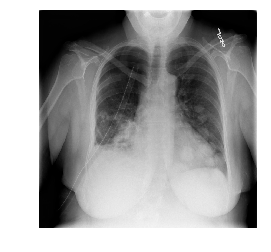

In [15]:
patientId = df_detailed['patientId'][0]
draw(parsed[patientId])

While the image displayed inline within the notebook is small, as a radiologist it is evident that the patient has several well circumscribed nodular densities in the left lung (right side of image). In addition there is a large chest tube in the right lung (left side of the image) which has been placed to drain fluid accumulation (e.g. pleural effusion) at the right lung base that also demonstrates overlying patchy densities (e.g. possibly atelectasis or partial lung collapse).

As you can see, there are a number of abnormalities on the image, and the determination that none of these findings correlate to pneumonia is somewhat subjective even among expert physicians. Therefore, as is almost always the case in medical imaging datasets, the provided ground-truth labels are far from 100% objective. Keep this in mind as you develop your algorithm, and consider consultation with a radiologist physician to help determine an optimal strategy for mitigating these discrepencies.

## Label Summary

Finally, let us take a closer look at the distribution of labels in the dataset. To do so we will first parse the detailed label information:

In [16]:
summary = {}
for n, row in df_detailed.iterrows():
    if row['class'] not in summary:
        summary[row['class']] = 0
    summary[row['class']] += 1
    
display(summary)

{'No Lung Opacity / Not Normal': 11500, 'Normal': 8525, 'Lung Opacity': 8964}

In [17]:
type(df_detailed)

pandas.core.frame.DataFrame

In [18]:
df_detailed['class'].value_counts()

No Lung Opacity / Not Normal    11500
Lung Opacity                     8964
Normal                           8525
Name: class, dtype: int64

As we can see, there is a relatively even split between the three classes, with nearly 2/3rd of the data comprising of no pneumonia (either completely *normal* or *no lung opacity / not normal*). Compared to most medical imaging datasets, where the prevalence of disease is quite low, this dataset has been significantly enriched with pathology.

# Next Steps

Now that you understand the data structures, imaging file formats and label types, it's time to make an algorithm! Keep in mind that the primary endpoint is the detection of bounding boxes, thus you will likely be considering various **object localization** algorithms. An alternative strategy is to consider the related family of **segmentation** algorithms with the acknowledgement that bounding boxes will only be a coarse approximation to true pixel-by-pixel image segmentation masks.

Finally, as alluded to several times in this notebook, a radiologist physican may often times provide useful ancillary information, strategy for algorithm development and/or additional label reconciliation. In addition to physicians you may have access to locally, the RSNA will reach out to radiologists and facilitate engagement remotely through the Kaggle online forums. As a medical professional, I know that many of my colleagues are very interested in getting started so please feel free to reach out and start a conversation! 

Good luck!

<span style='color:green'>Tom's Notes</span>

So what exactly am I trying to do here. I'm trying to detect pneumonia in an xray-type scan given to me as dicom files. 

Primarily there are two outputs (of a sort):
- Classification (normal, abnormal, pneumonia)
    - In these examples, normal and abnormal can be combined into 1 category such that there is binary yes/no for pneumonia. This may or may not be useful.
- Bounding box(es) for areas that contain the pneumonia

How am I planning on accomplishing theses tasks?
- We have just started learning about neural networks. As such, I can envision a classification NN that tells me whether or not there is pneumonia. Getting it to actually give me the coordinates, in some cases multiple coordinates, is a bit more difficult of a venture for me to see at the moment

What I've done:
- Read through the starter section of the kaggle competition
- Gone through this notebook, understanding how to view the dicom pics and relate them to their patient files and other meta data. 

Next steps:
- begin going through the forum for this competition
- I believe there is more material to reference before I go completely off on my own
- figure out exactly how the bounding boxes are measured
- look into 'object localization' and 'segmentation' algorithms

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

from numpy.random import seed
from tensorflow import set_random_seed

from skimage.transform import resize
import datetime
from tqdm import tqdm_notebook

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [20]:
seed(42)
set_random_seed(42)

In [21]:
df_detailed = pd.read_csv('../data/stage_1_detailed_class_info.csv')
print(df_detailed.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
class                No Lung Opacity / Not Normal
Name: 0, dtype: object


In [57]:
resized_shape = (128, 128)
num_images = df_detailed.shape[0]

In [58]:
male_adult_data = pd.read_csv('../data/male_adult_patient_data.csv')

In [59]:
male_adult_data.head(1)

,patientId,sex,age,viewPosition
0,00322d4d-1c29-4943-afc9-b6754be640eb,M,19,AP


In [60]:
df_detailed.head(1)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal


In [61]:
df_detailed.shape, male_adult_data.shape

((28989, 2), (15603, 4))

In [62]:
df_detailed.dtypes

patientId    object
class        object
dtype: object

In [63]:
male_adult_data.dtypes

patientId       object
sex             object
age              int64
viewPosition    object
dtype: object

In [ ]:
male_adult_data.drop_duplicates(inplace=True)

In [ ]:
merged_df = df_detailed.merge(male_adult_data, on='patientId')
merged_df.shape

In [ ]:
patientId = merged_df['patientId'][0]
dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

In [ ]:
im = dcm_data.pixel_array

In [ ]:
type(im)

In [ ]:
pixel_labels = []
for i in range(resized_shape[0] * resized_shape[1]):
    pixel_labels.append("pixel"+str(i))
pixel_labels[:10]

In [ ]:
%%time
final_pixel_array = []
for i in im:
    final_pixel_array.extend(i)

In [ ]:
final_pixel_array[:10]

In [ ]:
len(final_pixel_array), len(pixel_labels)

In [ ]:
from skimage.transform import resize

In [ ]:
test_img_array = resize(im, (256,256)) #Testing purposes to see how well the image resolution stands up

In [ ]:
pylab.imshow(test_img_array, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [ ]:
merged_df.shape

In [ ]:
merged_df.head(1)

In [ ]:
merged_df.iloc[0]['class']

In [ ]:
i = 0
[merged_df.iloc[i]['patientId'], merged_df.iloc[i]['class']]

In [ ]:
%%time

# Kernel breaks after like 10-15 minutes running against the whole set. Not scalable it would seem.

#trying out scaling the images down to 512x512

#setting up an array of 1d pixel arrays for all of the pics
huge_pixel_array = []
index = 0
y_df = []
for o in range(merged_df.shape[0]):
    # Get the image data
    patientId = merged_df.iloc[o]['patientId']
    dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_file)
    im = dcm_data.pixel_array
    
    #collect the class 
    #y_df.append([merged_df.iloc[o]['patientId'], merged_df.iloc[o]['class']])
    
    #convert the image into a 1d array of pixels
    final_pixel_array = []
    for i in resize(im, resized_shape): #resize the image into a 256x256 image instead of a 1024*1024. Might be too big in the long run still but we'll see
        final_pixel_array.extend(i)
    huge_pixel_array.append(final_pixel_array)
    
    
    
    index += 1
    if index == num_images:
        break

In [ ]:
#y = pd.DataFrame(data = y_df, columns = ['patientId', 'class'])

In [ ]:
y.head()

In [ ]:
%%time
temp = pd.DataFrame(data = huge_pixel_array, columns = pixel_labels)

In [ ]:
temp.head()

In [ ]:
temp.max().max() # Checking to make sure that the scaling was correctly done

In [ ]:
### Checking to make sure that the images still look like images
pylab.imshow(temp.iloc[0].values.reshape(resized_shape[0], resized_shape[1]), cmap=pylab.cm.gist_gray)
pylab.axis('off')

## Trying out modeling for the first time

In [ ]:
y = merged_df['class']

In [ ]:
y.head(1)

In [ ]:
y['class'].value_counts()

In [ ]:
y.shape, temp.shape

In [ ]:
y = y['class']

In [ ]:
the_map = {
    "Lung Opacity":0,
    "No Lung Opacity / Not Normal":1,
    "Normal":2
}
y = y.map(lambda x: the_map[x])

In [ ]:
X = temp


X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

In [ ]:
X_train_re = X_train.values.reshape(X_train.shape[0], resized_shape[0], resized_shape[1], 1)
X_test_re = X_test.values.reshape(X_test.shape[0], resized_shape[0], resized_shape[1], 1)

In [ ]:
# Initialize Model
model_convolutional = Sequential()

# First Conv / Pool 
model_convolutional.add(Conv2D(filters = 6,
                               kernel_size = 3,
                               activation = 'relu',
                               input_shape = (resized_shape[0], resized_shape[1], 1)
                              ))
model_convolutional.add(MaxPooling2D(pool_size=(2,2)))

#Second Conv/ Pool
model_convolutional.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
model_convolutional.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_convolutional.add(Dropout(0.5))
model_convolutional.add(Flatten())

model_convolutional.add(Dense(512, activation='relu'))
model_convolutional.add(Dense(128, activation='relu'))
model_convolutional.add(Dropout(0.5))
model_convolutional.add(Dense(3, activation='softmax'))

In [ ]:
model_convolutional.compile(loss = 'categorical_crossentropy', 
                            optimizer = 'adam', 
                            metrics = ['accuracy'])

In [ ]:
%%time

trained_convolutional = model_convolutional.fit(X_train_re,
                        y_train_c,
                        batch_size = 32,
                        epochs = 80,
                        verbose = 1,
                        validation_data = (X_test_re, y_test_c)
                       )

In [ ]:
plt.plot(trained_convolutional.history['loss'], label="Loss")
plt.plot(trained_convolutional.history['val_loss'], label='Val Loss')
plt.legend()

In [ ]:
plt.plot(trained_convolutional.history['acc'], label='Acc')
plt.plot(trained_convolutional.history['val_acc'], label='Val Acc')
plt.legend()

On a NN with 1k 256x256 images, 2 convolutional layers, 2 dense layers (512, 128) the scores were:

750/750 [==============================] - 19s 26ms/step - loss: 9.2196 - acc: 0.4280 - val_loss: 9.2196 - val_acc: 0.4280

<br>

I think it might be a lack of data kind of thing so I'm going to let it run on maybe 5k of the dataset with an image resolution of 128 and see what happens

3750/3750 [==============================] - 846s 226ms/step - loss: 1.0562 - acc: 0.4733 - val_loss: 1.0565 - val_acc: 0.4736

<br>

Given the fact that the accuracy increased a little, I am running it with all the data. Took out the Dropout from the model. It takes ~3min per epoch. The model hasn't gotten any better since epoch 2 and it's on 13 now. I'm going to stop it and tune. Probably should look into messing with features and creating an EC2 thing. 

21741/21741 [==============================] - 141s 6ms/step - loss: 1.0898 - acc: 0.3967 - val_loss: 1.0897 - val_acc: 0.3967


<br>

Added back in the dropout cases to the model. run overnight. Didn't finish. Got to like epoch 63. Hadn't changed since epoch 7.

1741/21741 [==============================] - 337s 16ms/step - loss: 1.0897 - acc: 0.3967 - val_loss: 1.0897 - val_acc: 0.3967

Potential things to do:
- make different models for sexes
- make different models for children vs adults (based on when the chest grows to essentially normalized size so like 16? 24?)
- use the EC2 instances
- change the y's around. make it binary (pnemonia/not pnemonia)
- make the images bigger than 128x128?
- try to optimize for false negatives



add in 2 nodes to the beginning, 1 for sex, 1 for position

In [ ]:
female_adult_data = pd.read_csv('../data/female_adult_patient_data.csv')

In [ ]:
female_adult_data.head(1)

In [ ]:
df_detailed.head(1)

In [ ]:
df_detailed.shape, male_adult_data.shape

In [ ]:
df_detailed.dtypes

In [ ]:
female_adult_data.dtypes

In [ ]:
female_adult_data.drop_duplicates(inplace=True)

In [ ]:
female_merged_df = df_detailed.merge(female_adult_data, on='patientId')
female_merged_df.shape

In [ ]:
patientId = merged_df['patientId'][0]
dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

In [ ]:
im = dcm_data.pixel_array

In [ ]:
type(im)

In [ ]:
pixel_labels = []
for i in range(resized_shape[0] * resized_shape[1]):
    pixel_labels.append("pixel"+str(i))
pixel_labels[:10]

In [ ]:
%%time
final_pixel_array = []
for i in im:
    final_pixel_array.extend(i)

In [ ]:
final_pixel_array[:10]

In [ ]:
len(final_pixel_array), len(pixel_labels)

In [ ]:
from skimage.transform import resize

In [ ]:
test_img_array = resize(im, (256,256)) #Testing purposes to see how well the image resolution stands up

In [ ]:
pylab.imshow(test_img_array, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [ ]:
female_merged_df.shape

In [ ]:
female_merged_df.head(1)

In [ ]:
female_merged_df.iloc[0]['class']

In [ ]:
i = 0
[female_merged_df.iloc[i]['patientId'], female_merged_df.iloc[i]['class']]

In [ ]:
%%time

# Kernel breaks after like 10-15 minutes running against the whole set. Not scalable it would seem.

#trying out scaling the images down to 512x512

#setting up an array of 1d pixel arrays for all of the pics
huge_pixel_array = []
index = 0
y_df = []
for o in range(female_merged_df.shape[0]):
    # Get the image data
    patientId = female_merged_df.iloc[o]['patientId']
    dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_file)
    im = dcm_data.pixel_array
    
    #collect the class 
    #y_df.append([merged_df.iloc[o]['patientId'], merged_df.iloc[o]['class']])
    
    #convert the image into a 1d array of pixels
    final_pixel_array = []#[female_merged_df.iloc[o]['sex'], female_merged_df.iloc[o]['age'], female_merged_df.iloc[o]['viewPosition']]
    for i in resize(im, resized_shape): #resize the image into a 256x256 image instead of a 1024*1024. Might be too big in the long run still but we'll see
        final_pixel_array.extend(i)
    huge_pixel_array.append(final_pixel_array)
    
    
    
    index += 1
    if index == num_images:
        break

In [ ]:
#y = pd.DataFrame(data = y_df, columns = ['patientId', 'class'])

In [ ]:
y.head()

In [ ]:
%%time
temp = pd.DataFrame(data = huge_pixel_array, columns = pixel_labels)# ['sex', 'age', 'viewPosition'].extend()

In [ ]:
temp.head()

In [ ]:
temp.max().max() # Checking to make sure that the scaling was correctly done

In [ ]:
### Checking to make sure that the images still look like images
pylab.imshow(temp.iloc[0].values.reshape(resized_shape[0], resized_shape[1]), cmap=pylab.cm.gist_gray)
pylab.axis('off')

## Trying out modeling for the first time

In [ ]:
y = female_merged_df['class']

In [ ]:
y.head(1)

In [ ]:
y['class'].value_counts()

In [ ]:
y.shape, temp.shape

In [ ]:
y = y['class']

In [ ]:
the_map = {
    "Lung Opacity":0,
    "No Lung Opacity / Not Normal":1,
    "Normal":2
}
y = y.map(lambda x: the_map[x])

In [ ]:
X = temp


X.shape, y.shape

In [ ]:
# Turning sex and view position into inputs for the NN
sex_map = {
    'M':0,
    'F':1
}

view_map = {
    'AP':0,
    'PA':1
}
X['sex'] = X['sex'].map(lambda x: sex_map(x))
X['viewPosition'] = X['viewPosition'].map(lambda x: view_map(x))

In [ ]:
X = X.drop(columns=['age','viewPosition','sex']) 
#I'm not sure how to add this into the inputs for the thing. 
#Maybe have a second NN that takes in this info and then applies it at the end, 
#kind of like how Mike's thing kind of works

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

In [ ]:
X_train_re = X_train.values.reshape(X_train.shape[0], resized_shape[0], resized_shape[1], 1)
X_test_re = X_test.values.reshape(X_test.shape[0], resized_shape[0], resized_shape[1], 1)

In [ ]:
# Initialize Model
model_convolutional_female = Sequential()

# First Conv / Pool 
model_convolutional_female.add(Conv2D(filters = 6,
                               kernel_size = 3,
                               activation = 'relu',
                               input_shape = (resized_shape[0], resized_shape[1], 1)
                              ))
model_convolutional_female.add(MaxPooling2D(pool_size=(2,2)))

#Second Conv/ Pool
model_convolutional_female.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
model_convolutional_female.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_convolutional_female.add(Dropout(0.5))
model_convolutional_female.add(Flatten())

model_convolutional_female.add(Dense(512, activation='relu'))
model_convolutional_female.add(Dense(128, activation='relu'))
model_convolutional_female.add(Dropout(0.5))
model_convolutional_female.add(Dense(3, activation='softmax'))

In [ ]:
model_convolutional_female.compile(loss = 'categorical_crossentropy', 
                            optimizer = 'adam', 
                            metrics = ['accuracy'])

In [ ]:
%%time

trained_convolutional_female = model_convolutional_female.fit(X_train_re,
                        y_train_c,
                        batch_size = 32,
                        epochs = 80,
                        verbose = 1,
                        validation_data = (X_test_re, y_test_c)
                       )

In [ ]:
plt.plot(trained_convolutional_female.history['loss'], label="Loss")
plt.plot(trained_convolutional_female.history['val_loss'], label='Val Loss')
plt.legend()

In [ ]:
plt.plot(trained_convolutional_female.history['acc'], label='Acc')
plt.plot(trained_convolutional_female.history['val_acc'], label='Val Acc')
plt.legend()

# All Adult Data

In [ ]:
adult_data = pd.read_csv('../data/adult_patient_data.csv')

In [ ]:
adult_data.head(1)

In [ ]:
df_detailed.head(1)

In [ ]:
df_detailed.shape, adult_data.shape

In [ ]:
df_detailed.dtypes

In [ ]:
adult_data.dtypes

In [ ]:
adult_data.drop_duplicates(inplace=True)

In [ ]:
merged_df = df_detailed.merge(adult_data, on='patientId')
merged_df.shape

In [ ]:
patientId = merged_df['patientId'][0]
dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

In [ ]:
im = dcm_data.pixel_array

In [ ]:
type(im)

In [ ]:
pixel_labels = []
for i in range(resized_shape[0] * resized_shape[1]):
    pixel_labels.append("pixel"+str(i))
pixel_labels[:10]

In [ ]:
%%time
final_pixel_array = []
for i in im:
    final_pixel_array.extend(i)

In [ ]:
final_pixel_array[:10]

In [ ]:
len(final_pixel_array), len(pixel_labels)

In [ ]:
from skimage.transform import resize

In [ ]:
test_img_array = resize(im, (256,256)) #Testing purposes to see how well the image resolution stands up

In [ ]:
pylab.imshow(test_img_array, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [ ]:
merged_df.shape

In [ ]:
merged_df.head(1)

In [ ]:
merged_df.iloc[0]['class']

In [ ]:
i = 0
[merged_df.iloc[i]['patientId'], merged_df.iloc[i]['class']]

In [ ]:
%%time
#trying out scaling the images down to 512x512

#setting up an array of 1d pixel arrays for all of the pics
huge_pixel_array = []
index = 0
y_df = []
for o in range(merged_df.shape[0]):
    # Get the image data
    patientId = merged_df.iloc[o]['patientId']
    dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_file)
    im = dcm_data.pixel_array
    
    #collect the class 
    #y_df.append([merged_df.iloc[o]['patientId'], merged_df.iloc[o]['class']])
    
    #convert the image into a 1d array of pixels
    final_pixel_array = []
    for i in resize(im, resized_shape): 
        final_pixel_array.extend(i)
    huge_pixel_array.append(final_pixel_array)
    
    
    
    index += 1
    if index == num_images:
        break

In [ ]:
#y = pd.DataFrame(data = y_df, columns = ['patientId', 'class'])

In [ ]:
#y.head()

In [ ]:
%%time
temp = pd.DataFrame(data = huge_pixel_array, columns = pixel_labels)

In [ ]:
temp.head()

In [ ]:
temp.max().max() # Checking to make sure that the scaling was correctly done

In [ ]:
### Checking to make sure that the images still look like images
pylab.imshow(temp.iloc[0].values.reshape(resized_shape[0], resized_shape[1]), cmap=pylab.cm.gist_gray)
pylab.axis('off')

## Trying out modeling for the first time

In [ ]:
y = merged_df['class']

In [ ]:
y.head(1)

In [ ]:
#y['class'].value_counts()

In [ ]:
y.shape, temp.shape

In [ ]:
#y = y['class']

In [ ]:
the_map = {
    "Lung Opacity":0,
    "No Lung Opacity / Not Normal":1,
    "Normal":2
}
y = y.map(lambda x: the_map[x])

In [ ]:
X = temp


X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

In [ ]:
X_train_re = X_train.values.reshape(X_train.shape[0], resized_shape[0], resized_shape[1], 1)
X_test_re = X_test.values.reshape(X_test.shape[0], resized_shape[0], resized_shape[1], 1)

In [75]:
# Initialize Model
model_convolutional = Sequential()

# First Conv / Pool 
model_convolutional.add(Conv2D(filters = 6,
                               kernel_size = 3,
                               activation = 'relu',
                               input_shape = (resized_shape[0], resized_shape[1], 1)
                              ))
model_convolutional.add(MaxPooling2D(pool_size=(2,2)))

#Second Conv/ Pool
model_convolutional.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
model_convolutional.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_convolutional.add(Dropout(0.8))
model_convolutional.add(Flatten())

model_convolutional.add(Dense(512, activation='relu'))
model_convolutional.add(Dropout(0.5))
model_convolutional.add(Dense(128, activation='relu'))
model_convolutional.add(Dropout(0.5))
model_convolutional.add(Dense(3, activation='softmax'))

changed post-conv dropout to 0.8 and added a dropout 0.5 between dense layers

In [ ]:
model_convolutional.compile(loss = 'categorical_crossentropy', 
                            optimizer = 'adam', 
                            metrics = ['accuracy'])

In [ ]:
%%time

trained_convolutional = model_convolutional.fit(X_train_re,
                        y_train_c,
                        batch_size = 32,
                        epochs = 80,
                        verbose = 1,
                        validation_data = (X_test_re, y_test_c)
                       )

In [ ]:
plt.plot(trained_convolutional.history['loss'], label="Loss")
plt.plot(trained_convolutional.history['val_loss'], label='Val Loss')
plt.legend()

In [ ]:
plt.plot(trained_convolutional.history['acc'], label='Acc')
plt.plot(trained_convolutional.history['val_acc'], label='Val Acc')
plt.legend()

# Building Function

Writing a function to put all of my modling into since it is getting difficult to actually differentiate


In [65]:
class PnemoniaTargetMapIsWeird(AssertionError):
    """Raise this when the target is not mapped to 2 or 3 outputs"""
    pass

In [109]:
def create_pic_df(data, df_detailed, image_size = (128,128)):
    
    print('---Enter DataFrame Construction Function---')
    
    ## Data Prep
    # Need to define df_detailed somewhere
    data.drop_duplicates(inplace=True)
    merged_df = df_detailed.merge(data, on='patientId')
    
    print('---Create Pixel Array Labels---')
    
    # Create the column labels for the pixel arrays
    pixel_labels = []
    for i in range(image_size[0] * image_size[1]):
        pixel_labels.append("pixel"+str(i))
    
    print('---Create Total Pixel Array---')
    
    # Create the total pixel array
    huge_pixel_array = []
    for o in tqdm_notebook(range(merged_df.shape[0])):
        # Get the image data
        patientId = merged_df.iloc[o]['patientId']
        dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
        dcm_data = pydicom.read_file(dcm_file)
        im = dcm_data.pixel_array

        # Convert the image into a 1d array of pixels
        curr_pixel_array = []
        for i in resize(im, image_size): 
            curr_pixel_array.extend(i)
        huge_pixel_array.append(curr_pixel_array)

    print('---Create Dataframe---')
        
    # Creating the DataFrame
    temp = pd.DataFrame(data = huge_pixel_array, columns = pixel_labels)
    temp['class'] = merged_df['class']
    return temp

In [118]:
def model(data, model_name = "default_model_name", image_size = (128,128), y_map = {
    "Lung Opacity":0,
    "No Lung Opacity / Not Normal":1,
    "Normal":2
}, EPOCHS = 20 ):
    """
    Args:
        data (Pandas DataFrame): cols=['class', all of the pixel data]
        model_name (str): The name with which to save the model
        image_size (touple: (int,int)): The width and height in pixels to scale the images. 
                Max 1024x1024. This might be more finickey that I would've thought.
        y_map (dict): A dictionary mapping the target values to integers (0-?)
        
    Returns:
        Keras Model fit on the data.
        Saves the model to ../data/models/model_name datetime.h5
    """
    print('---Enter Function---')
    

    # Create target
    y = data['class']
    y = y.map(lambda x: y_map[x])
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='class'), y, 
                                                        stratify=y, random_state=42)
    
    # Transform target into arrays of integers
    y_train_c = to_categorical(y_train)
    y_test_c = to_categorical(y_test)
    
    # Reshape the X_train and X_test 
    X_train_re = X_train.values.reshape(X_train.shape[0], image_size[0], image_size[1], 1)
    X_test_re = X_test.values.reshape(X_test.shape[0], image_size[0], image_size[1], 1)
    
    print('---Modeling---')
    
    ## Modeling
    # Initialize Model
    model_convolutional = Sequential()

    # First Conv / Pool 
    model_convolutional.add(Conv2D(filters = 6,
                                   kernel_size = 3,
                                   activation = 'relu',
                                   input_shape = (resized_shape[0], resized_shape[1], 1)
                                  ))
    model_convolutional.add(MaxPooling2D(pool_size=(2,2)))

    # Second Conv/ Pool
    model_convolutional.add(Conv2D(filters=16, kernel_size=3, 
                                   activation='relu'))
    model_convolutional.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten
    model_convolutional.add(Dropout(0.8))
    model_convolutional.add(Flatten())

    # Densely Connected Layers
    model_convolutional.add(Dense(512, activation='relu'))
    model_convolutional.add(Dropout(0.5))
    model_convolutional.add(Dense(128, activation='relu'))
    model_convolutional.add(Dropout(0.5))
    
    # Output Layer
    if len(y_map) == 3:
        model_convolutional.add(Dense(3, activation='softmax'))
    elif len(y_map) == 2:
        model_convolutional.add(Dense(2, activation='softmax'))
    else:
        raise PnemoniaTargetMapIsWeird("target is not mapped to 2 or 3 outputs")


    model_convolutional.compile(loss = 'categorical_crossentropy', 
                            optimizer = 'adam', 
                            metrics = ['accuracy'])
    
    # Train Model
    trained_convolutional = model_convolutional.fit(X_train_re,
                        y_train_c,
                        batch_size = 32,
                        epochs = EPOCHS,
                        verbose = 1,
                        validation_data = (X_test_re, y_test_c)
                       )

    # Save Model 
    try:
        file_name = '../data/models/' + model_name + ' ' + str(datetime.datetime.now()) + '.h5'
        
        model_convolutional.save(file_name)
        print('Model saved as: ' + file_name)
        
    except Exception as e:
        print('Model did not save.')
        print(e)
        
        
    return trained_convolutional, model_convolutional



In [111]:
adult_data = pd.read_csv('../data/adult_patient_data.csv')
EPOCHS = 2
IMAGE_SIZE = (128,128)


# Lung Opacity == Pneumonia
y_map_3 = { # Normal, Pneumonia, or not normal but not pneumonia
    "Lung Opacity":0,
    "No Lung Opacity / Not Normal":1,
    "Normal":2
}

y_map_2 = { # Either Pneumonia or Not Pneumonia
    "Lung Opacity":0,
    "No Lung Opacity / Not Normal":1,
    "Normal":1
}

In [112]:
%%time

pic_df = create_pic_df(adult_data, df_detailed=df_detailed, image_size=IMAGE_SIZE)

---Enter DataFrame Construction Function---
---Create Pixel Array Labels---
---Create Total Pixel Array---


/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



---Create Dataframe---
CPU times: user 8min 57s, sys: 12.9 s, total: 9min 10s
Wall time: 9min 9s


In [119]:
%%time

print('Beginning Model Building!')
test_model_history, test_model_real = model(pic_df, model_name = 'adult_data_3options', 
                                            y_map=y_map_3, EPOCHS=EPOCHS)
print('Model Finished Building!')


Beginning Model Building!
---Enter Function---
---Modeling---
Train on 20652 samples, validate on 6885 samples
Epoch 1/2
20652/20652 [==============================] - 120s 6ms/step - loss: 0.9152 - acc: 0.5397 - val_loss: 0.8571 - val_acc: 0.5781
Epoch 2/2
20652/20652 [==============================] - 118s 6ms/step - loss: 0.8653 - acc: 0.5736 - val_loss: 0.8340 - val_acc: 0.6019
Model saved as: ../data/models/adult_data_3options 2018-10-16 19:53:07.642132.h5
Model Finished Building!
CPU times: user 16min 39s, sys: 5min, total: 21min 40s
Wall time: 4min 6s


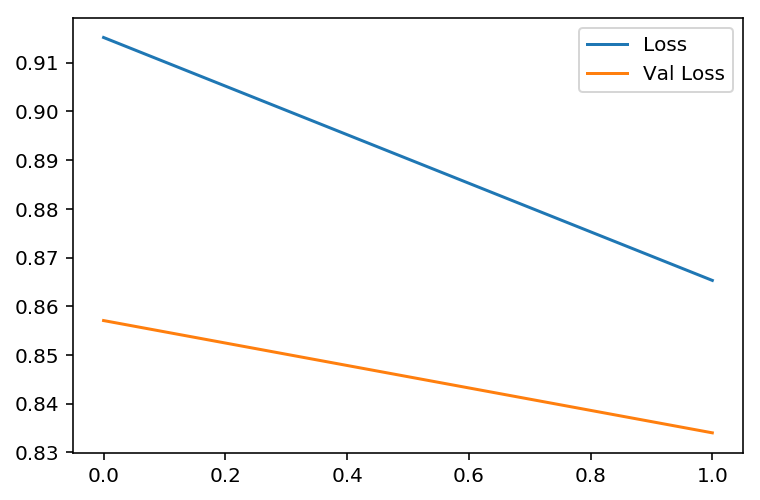

In [120]:
plt.plot(test_model_history.history['loss'], label="Loss")
plt.plot(test_model_history.history['val_loss'], label='Val Loss')
plt.legend()

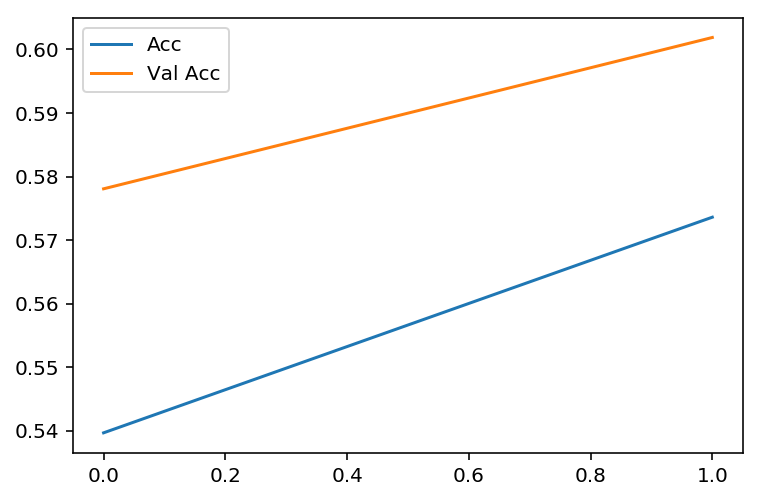

In [121]:
plt.plot(test_model_history.history['acc'], label='Acc')
plt.plot(test_model_history.history['val_acc'], label='Val Acc')
plt.legend()

In [142]:
test_model_history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

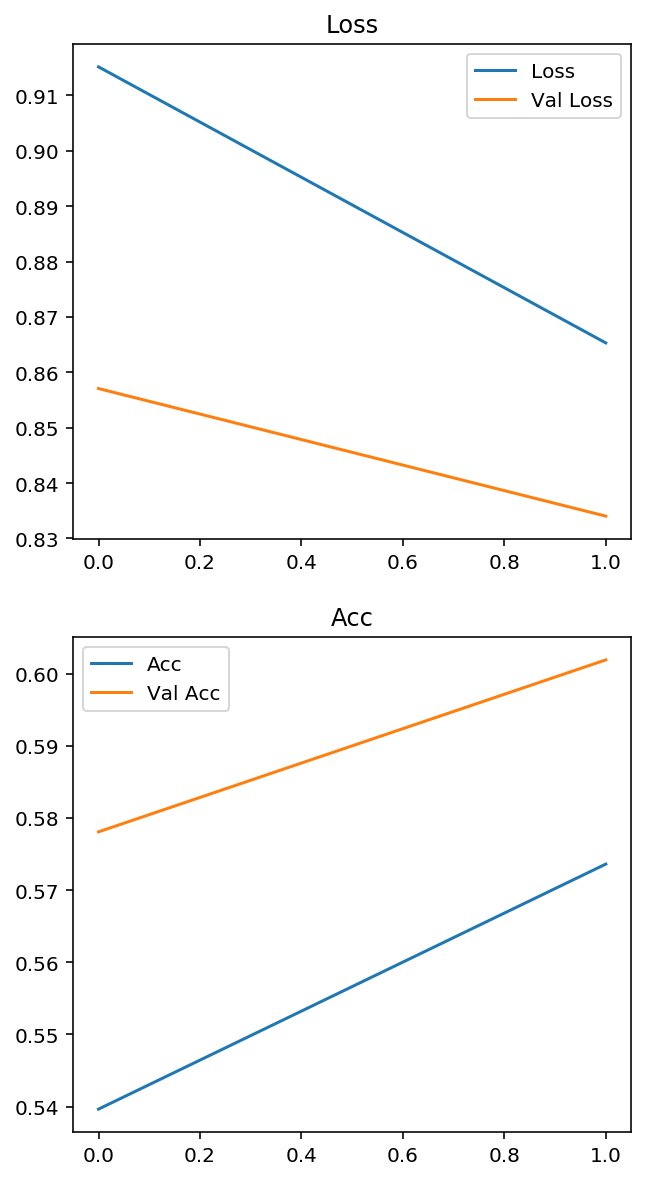

In [152]:
evaluate_model(test_model_history)


In [151]:
# Function that displays pertinant information regarding the quality of the model

def evaluate_model (model, size=5):
    
    """
    Args:
        model: A trained model with 
        
    Output:
        Returns nothing. Prints out - plots comparing test set with training set on 
        each of the metrics (minimum: loss).
    
    """
    
    # checking out the different classes in the testing case and predictions
    
    # confusion matrix?
    
    keys=[]
    for i in model.history.keys():
        if i[0:3] != 'val':
            keys.append(i)
    
    fig, ax = plt.subplots(len(keys), 1, figsize = (size, size*len(keys))) 
    
    index = 0
    for i in keys:
        # Plot of the Loss for the train and testingsets
        ax[index].plot(model.history[i], label=i.capitalize())
        ax[index].plot(model.history['val_'+i], label='Val '+i.capitalize())
        ax[index].legend()
        ax[index].set_title(i.capitalize())
        index+=1
